In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
from IPython.display import Image
import math
from torchvision.datasets import ImageFolder
import torchvision.transforms as T




In [2]:
print('looping for 85 epochs')

looping for 85 epochs


In [3]:


image_size = 32
batch_size = 3
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)



In [4]:
DATA_DIR = "/kaggle/input/animefacedataset" #/kaggle/input/animefacedataset

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

In [6]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


In [9]:
from torchvision.utils import make_grid

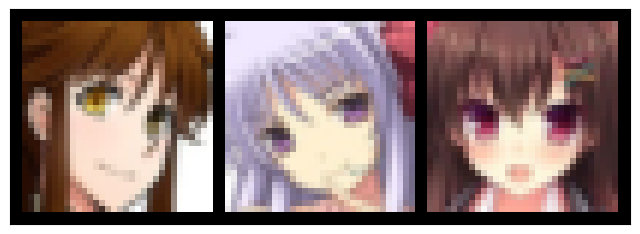

In [10]:
show_batch(train_dl)

In [11]:
def show_images(images, title=""):
    # Get number of images
    num_images = len(images)

    # Determine number of rows and columns needed for the subplots
    num_rows = int(math.sqrt(num_images))
    num_cols = math.ceil(num_images / num_rows)

    # Create figure and add subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    fig.suptitle(title, fontsize=30)

    # Display each image in its corresponding subplot
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            ax.imshow(images[i].permute(1, 2, 0).numpy(), cmap="gray")
            ax.axis("off")

    # Show the figure
    plt.show()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    positions = torch.arange(n).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2) * -(math.log(10000.0) / d))
    embeddings = torch.zeros(n, d)

    # Compute the sinusoidal embeddings
    embeddings[:, 0::2] = torch.sin(positions * div_term)
    embeddings[:, 1::2] = torch.cos(positions * div_term)

    return embeddings

In [14]:
class ConvNet(nn.Module):
    def __init__(
        self,
        input_shape,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normalize=True,
    ):
        super(ConvNet, self).__init__()
        self.layer_norm = nn.LayerNorm(input_shape)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.layer_norm(x) if self.normalize else x
        out = self.conv(out)
        out = self.activation(out)
        return out


def convolution_block(image_size, in_channels, out_channels):
    return nn.Sequential(
        ConvNet((in_channels, image_size, image_size), in_channels, out_channels),
        ConvNet((out_channels, image_size, image_size), out_channels, out_channels),
        ConvNet((out_channels, image_size, image_size), out_channels, out_channels),
    )


def tiny_upsampling_block(image_size, in_channels):
    return nn.Sequential(
        ConvNet((in_channels, image_size, image_size), in_channels, in_channels // 2),
        ConvNet((in_channels // 2, image_size, image_size), in_channels // 2, in_channels // 4),
        ConvNet((in_channels // 4, image_size, image_size), in_channels // 4, in_channels // 4),
    )

In [15]:
class TinyUNet(nn.Module):

    def _make_time_embedding_layer(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.SiLU(),
            nn.Linear(output_dim, output_dim)
        )

    def __init__(self, input_channels=3, output_channels=3, size=32, num_steps=1000, time_emb_dim=100):
        super(TinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embedding = nn.Embedding(num_steps, time_emb_dim)
        self.time_embedding.weight.data = sinusoidal_embedding(num_steps, time_emb_dim)
        self.time_embedding.requires_grad_(False)

        # First half
        self.time_embed_1 = self._make_time_embedding_layer(time_emb_dim, 1)
        self.conv_block_1 = convolution_block(size, input_channels, 10)
        self.downsampling_1 = nn.Conv2d(10, 10, kernel_size=4, stride=2, padding=1)
        self.time_embed_2 = self._make_time_embedding_layer(time_emb_dim, 10)
        self.conv_block_2 = convolution_block(size // 2, 10, 20)
        self.downsampling_2 = nn.Conv2d(20, 20, kernel_size=4, stride=2, padding=1)
        self.time_embed_3 = self._make_time_embedding_layer(time_emb_dim, 20)
        self.conv_block_3 = convolution_block(size // 4, 20, 40)
        self.downsampling_3 = nn.Conv2d(40, 40, kernel_size=4, stride=2, padding=1)

        # Bottleneck
        self.time_embed_mid = self._make_time_embedding_layer(time_emb_dim, 40)
        self.bottleneck = nn.Sequential(
            ConvNet((40, size // 8, size // 8), 40, 20),
            ConvNet((20, size // 8, size // 8), 20, 20),
            ConvNet((20, size // 8, size // 8), 20, 40),
        )

        # Second half
        self.upsampling_1 = nn.ConvTranspose2d(40, 40, kernel_size=4, stride=2, padding=1)
        self.time_embed_4 = self._make_time_embedding_layer(time_emb_dim, 80)
        self.upsampling_block_1 = tiny_upsampling_block(size // 4, 80)
        self.upsampling_2 = nn.ConvTranspose2d(20, 20, kernel_size=4, stride=2, padding=1)
        self.time_embed_5 = self._make_time_embedding_layer(time_emb_dim, 40)
        self.upsampling_block_2 = tiny_upsampling_block(size // 2, 40)
        self.upsampling_3 = nn.ConvTranspose2d(10, 10, kernel_size=4, stride=2, padding=1)
        self.time_embed_out = self._make_time_embedding_layer(time_emb_dim, 20)
        self.conv_block_out = convolution_block(size, 20, 10)
        self.output_convolution = nn.Conv2d(10, output_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t):
        # Apply time embedding to t
        t_embedded = self.time_embedding(t)
        
        # Pass input through first set of convolutions
        n = len(x)
        out1 = self.conv_block_1(x + self.time_embed_1(t_embedded).reshape(n, -1, 1, 1))
        out2 = self.conv_block_2(self.downsampling_1(out1) + self.time_embed_2(t_embedded).reshape(n, -1, 1, 1))
        out3 = self.conv_block_3(self.downsampling_2(out2) + self.time_embed_3(t_embedded).reshape(n, -1, 1, 1))

        # Pass through middle set of convolutions
        out_mid = self.bottleneck(self.downsampling_3(out3) + self.time_embed_mid(t_embedded).reshape(n, -1, 1, 1))

        # Pass through last set of convolutions, using skip connections to combine with previous layers
        out4 = torch.cat((out3, self.upsampling_1(out_mid)), dim=1)
        out4 = self.upsampling_block_1(out4 + self.time_embed_4(t_embedded).reshape(n, -1, 1, 1))
        out5 = torch.cat((out2, self.upsampling_2(out4)), dim=1)
        out5 = self.upsampling_block_2(out5 + self.time_embed_5(t_embedded).reshape(n, -1, 1, 1))
        out = torch.cat((out1, self.upsampling_3(out5)), dim=1)
        out = self.conv_block_out(out + self.time_embed_out(t_embedded).reshape(n, -1, 1, 1))
        out = self.output_convolution(out)
        return out

In [16]:
bs = 3 # bs =3
x = torch.randn(bs, 3, 32, 32)
n_steps = 1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = TinyUNet(input_channels=3, output_channels=3, size=32)

In [17]:
class DDPM(nn.Module):
    def __init__(
        self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device
    ) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(
            beta_start, beta_end, num_timesteps, dtype=torch.float32
        ).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod**0.5  # used in add_noise
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod).pow(0.5)  # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]  
        s1 = s1.reshape(-1, 1, 1, 1)  
        s2 = s2.reshape(-1, 1, 1, 1)  
        return s1 * x_start + s2 * x_noise

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)

    def step(self, model_output, timestep, sample):
        # one step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1 - self.alphas) / self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1, 1, 1, 1)
        coef_first = 1 / self.alphas.pow(0.5)
        coef_first_t = coef_first[t].reshape(-1, 1, 1, 1)
        pred_prev_sample = coef_first_t * (sample - coef_eps_t * model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = (self.betas[t].pow(0.5)) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

In [18]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

In [19]:
network = TinyUNet(input_channels=3, output_channels=3, size=32)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
print(f"The number of trainable parameters in the model is {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

The number of trainable parameters in the model is 441990


In [20]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    losses = []

    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
        for _, batch in enumerate(progress_bar):
            batch = batch[0].to(device)
            noise = torch.randn_like(batch).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],), dtype=torch.long).to(device)

            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)
            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            progress_bar.set_postfix(loss=loss.item())
        
        progress_bar.close()

    return losses

In [21]:
learning_rate = 1e-3
num_epochs = 85
num_timesteps = 1000
network = TinyUNet()
network = network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
losses = training_loop(model, train_dl, optimizer, num_epochs, num_timesteps, device=device)

Epoch 0:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 61:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 81:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/21189 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/21189 [00:00<?, ?it/s]

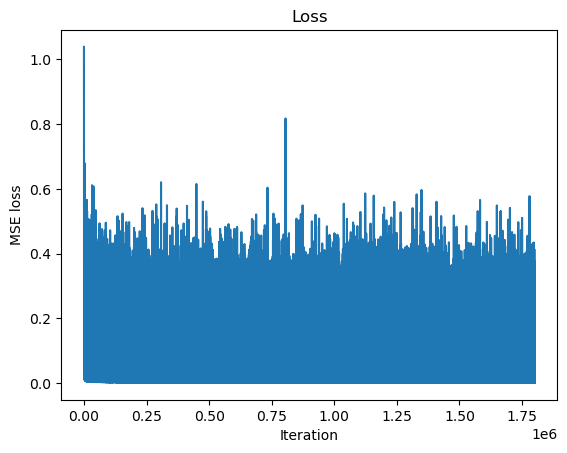

In [22]:
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.show()

In [23]:
def generate_image(ddpm, sample_size, channel, size):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)

        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t == 500:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

  0%|          | 0/1000 [00:00<?, ?it/s]

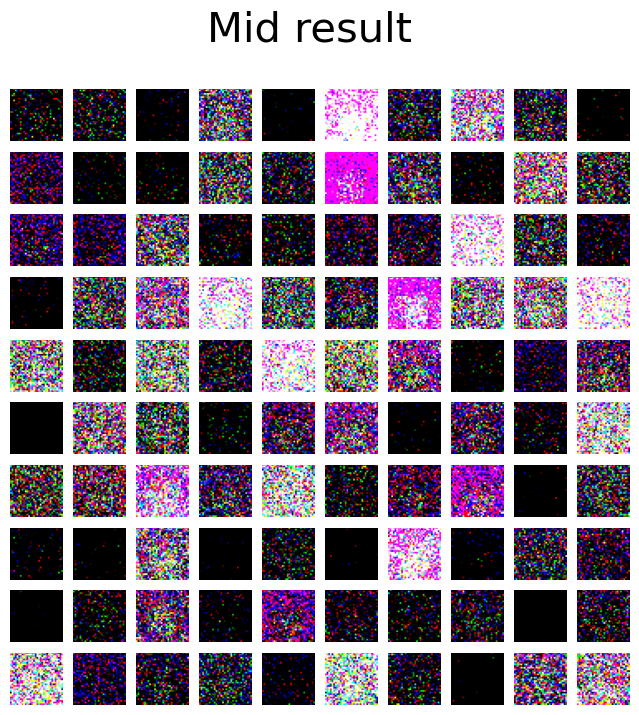

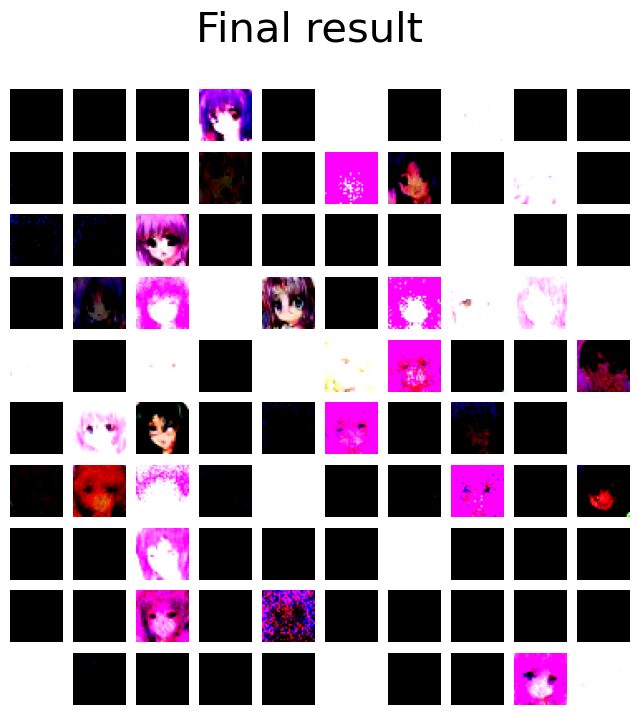

In [24]:
# generate the image using generate_image
generated, generated_mid = generate_image(model, 100, 3, 32)
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")